# USE CASE 1
Read `data/consumption.csv` to assess requirement of data cleaning and then spliting the data to test and traing. 

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sns.set()

# importing material data
dataM = pd.read_csv("../data/consumption.csv", sep=';')
dataM

,Material,Month,Consumption
0,A7B91500019666,201310,11542
1,A7B91500019666,201311,12192
2,A7B91500019666,201312,15213
3,A7B91500019666,201401,13893
4,A7B91500019666,201402,12190
...,...,...,...
110,A7B91500019666,202302,35805
111,A7B91500019666,202303,66327
112,A7B91500019666,202304,53814
113,A7B91500019666,202305,43821


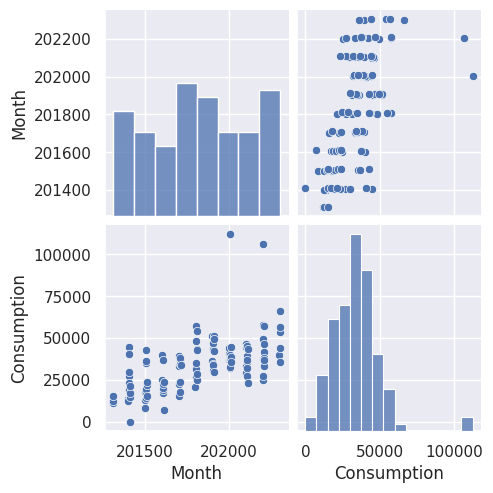

In [2]:
sns.pairplot(dataM)

In [3]:
#  check for empty data
dataM.isnull().any()

Material       False
Month          False
Consumption    False
dtype: bool

## Removing Outliers

In the pair plot it seems two datapoints are an outlier due to huge consumption. 

In [4]:
high_mask = dataM['Consumption'] >= 1e5

high_cons = dataM.loc[high_mask]
high_cons

,Material,Month,Consumption
77,A7B91500019666,202005,112184
101,A7B91500019666,202205,106237


As these are only two data points we consider them as outliers. After removing values higher than 1e5, it seems there are some materials with zero consumptions. Before removing them it is better to look closer at these specific data.

In [5]:
zero_mask = dataM['Consumption'] == 0

zero_cons = dataM.loc[zero_mask]
zero_cons

,Material,Month,Consumption
12,A7B91500019666,201410,0


As this is also only one value, it is good to add it to outliers. So the final cleaned data and outliers are:

In [6]:
outliers = dataM.loc[zero_mask | high_mask]
outliers

,Material,Month,Consumption
12,A7B91500019666,201410,0
77,A7B91500019666,202005,112184
101,A7B91500019666,202205,106237


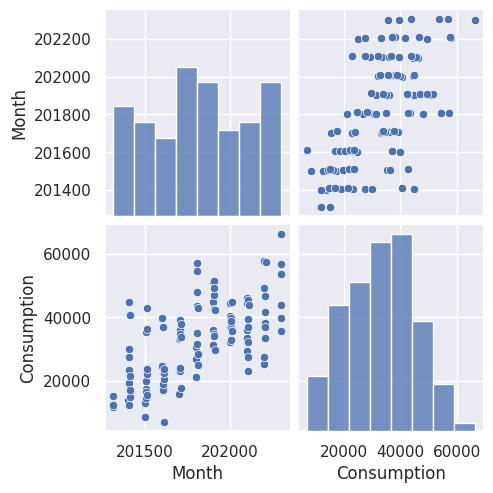

In [7]:
dataM_clean = dataM.loc[~zero_mask & ~high_mask]
sns.pairplot(dataM_clean)

# Data Encoding
The material type needs to be encoded to be fed into the model. Before that it is good to have an overview of material types.

In [8]:
dataM_clean.Material.unique()

array(['A7B91500019666'], dtype=object)

Split the Month column to a year and month:

In [9]:
data = dataM_clean.copy()
data['YearMonth'] = data['Month'].astype(str)

# convert valid datetime
data['Year'] = data['YearMonth'].str[:4] 
data['Month'] = data['YearMonth'].str[-2:] 



As all the material type is the same, this column can be removed from the data. 

In [10]:
# defining evaluation metric
def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    
    rmse = sqrt(mean_squared_error(actual, prediction))
    
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    
    return rmse

# Data Modeling - Senario1: predict yearly
Modeling each year consumption and forecast the coming two years. This will limit the data, but a good baseline.

## lazy estimator

In [11]:
# calculate yearly consumption
consumption_yearly = []
year_list = np.array(data['Year'].unique().astype(int))

for ci in year_list:
    yr_msk = data['Year'] == str(ci)
    consumption_yearly.append(data.loc[yr_msk].Consumption.sum())

# Create the scatter plot using Plotly
df = pd.DataFrame({
    'Year':year_list, 
    'consumption_yearly':consumption_yearly})
fig = px.scatter(df, x='Year', y='consumption_yearly', title='Total Consumption per Year')
fig.show()


In [12]:
# count number of month per year
count = []
for xi in year_list:
    yr_msk = data['Year'] == str(xi)
    count.append(data.loc[yr_msk].Consumption.count())
count

[3, 11, 12, 10, 12, 12, 12, 11, 12, 11, 6]

as the number of months are not equal, it will be best to look at mean per months.

In [13]:
df['avg_year_consumption'] = df['consumption_yearly']/count
fig = px.scatter(df, x='Year', y='avg_year_consumption', title='Average Consumption per Year')
fig.show()

In [14]:
X = df.loc[:, 'Year'].values.reshape(-1, 1)
y = df.loc[:, 'avg_year_consumption'].values

lazy_estimator_predictions = pd.DataFrame(y.copy())

# using median of entire training set
lazy_estimator_predictions.loc[:,'lazy_predicted_price'] = y.mean()
lazy_estimator_predictions.head().round()

,0,lazy_predicted_price
0,12982.0,32298.0
1,24081.0,32298.0
2,22073.0,32298.0
3,23330.0,32298.0
4,29330.0,32298.0


In [15]:
lazy_estimator_rmse = compute_rmse(y, lazy_estimator_predictions.loc[:, 'lazy_predicted_price'])

RMSE is  10262.97


## Linear Regression
A linear regression model might predict better results. But we still do it on the year data.

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:

# as the data overfit with descion trees, we will plit the data to test and train,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
linear_regression_predictions_test = linear_regression_model.predict(X_test)
linear_regression_predictions_train = linear_regression_model.predict(X_train)

linear_regression_rmse = compute_rmse(y_test, linear_regression_predictions_test)

RMSE is  4295.78


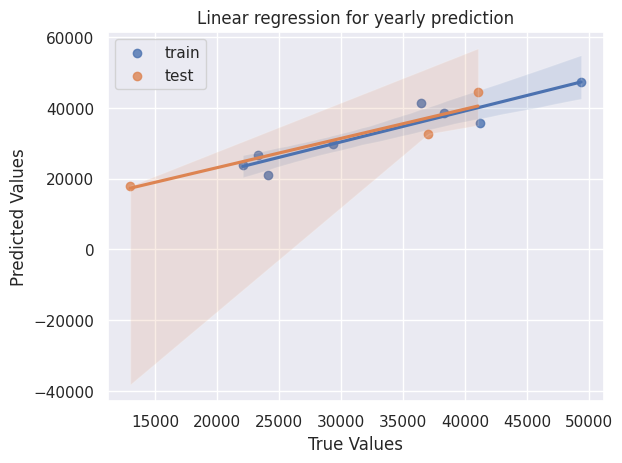

In [19]:
sns.regplot(x=y_train, y=linear_regression_predictions_train, label='train')
sns.regplot(x=y_test, y=linear_regression_predictions_test, label='test')

# Set plot labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Linear regression for yearly prediction')

# Add legend
plt.legend()

# Data Modeling - Scenario 2: monthly prediction
Modeling monthly consumption and predict the next 24 month. 

## Random Forest Model
In this way month data can also be included in the data modeling.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [21]:

# Create a MinMaxScaler object
scaler = MinMaxScaler()
data['month_norm'] = scaler.fit_transform(data[['Month']])
data['year_norm'] = scaler.fit_transform(data[['Year']])
data

,Material,Month,Consumption,YearMonth,Year,month_norm,year_norm
0,A7B91500019666,10,11542,201310,2013,0.818182,0.0
1,A7B91500019666,11,12192,201311,2013,0.909091,0.0
2,A7B91500019666,12,15213,201312,2013,1.000000,0.0
3,A7B91500019666,01,13893,201401,2014,0.000000,0.1
4,A7B91500019666,02,12190,201402,2014,0.090909,0.1
...,...,...,...,...,...,...,...
110,A7B91500019666,02,35805,202302,2023,0.090909,1.0
111,A7B91500019666,03,66327,202303,2023,0.181818,1.0
112,A7B91500019666,04,53814,202304,2023,0.272727,1.0
113,A7B91500019666,05,43821,202305,2023,0.363636,1.0


In [22]:
keep_col = ['year_norm', 'month_norm']
keep_col = ['Year', 'Month']
X_2 = data.copy(deep=True)[keep_col]
y_2 = data.copy(deep=True)['Consumption']

# as the data overfit with descion trees, we will plit the data to test and train,
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [23]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train_2, y_train_2)
random_forest_predictions_test = random_forest_model.predict(X_test_2)
random_forest_predictions_train = random_forest_model.predict(X_train_2)

random_forest_rmse = compute_rmse(y_test_2, random_forest_predictions_test)

RMSE is  8578.68


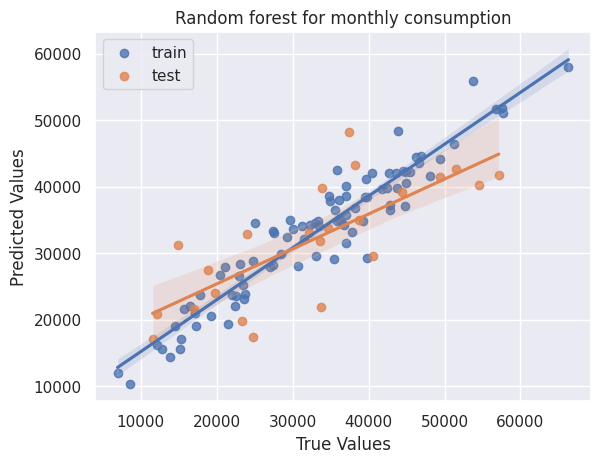

In [24]:
sns.regplot(x=y_train_2, y=random_forest_predictions_train, label='train')
sns.regplot(x=y_test_2, y=random_forest_predictions_test, label='test')

# Set plot labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random forest for monthly consumption')

# Add legend
plt.legend()

## Decision Tree Regression

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train_2, y_train_2)
decision_tree_predictions_test = decision_tree_model.predict(X_test_2)
decision_tree_predictions_train = decision_tree_model.predict(X_train_2)

decision_tree_rmse = compute_rmse(y_test_2, decision_tree_predictions_test)

RMSE is  11642.28


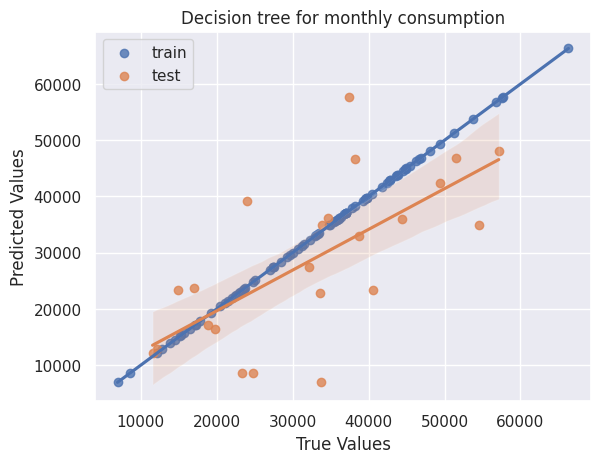

In [27]:
sns.regplot(x=y_train_2, y=decision_tree_predictions_train, label='train')
sns.regplot(x=y_test_2, y=decision_tree_predictions_test, label='test')


# Set plot labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Decision tree for monthly consumption')

# Add legend
plt.legend()

## Time Series

In [109]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

import warnings
# Suppress the "ValueWarning" messages
warnings.filterwarnings("ignore")

In [110]:
data_ts = dataM_clean.copy()
data_ts_v = data_ts.drop(columns=['Material', 'Month'])

In [176]:
arima_model = sm.tsa.ARIMA(data_ts_v, order=(30, 2, 5))
arima_model_fit = arima_model.fit()


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  112
Model:                ARIMA(30, 2, 5)   Log Likelihood               -1154.369
Date:                Wed, 02 Aug 2023   AIC                           2380.738
Time:                        19:13:51   BIC                           2477.955
Sample:                             0   HQIC                          2420.169
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6108      0.298     -5.401      0.000      -2.195      -1.026
ar.L2         -2.5444      0.440     -5.779      0.000      -3.407      -1.682
ar.L3         -2.7259      0.596     -4.577      0.0

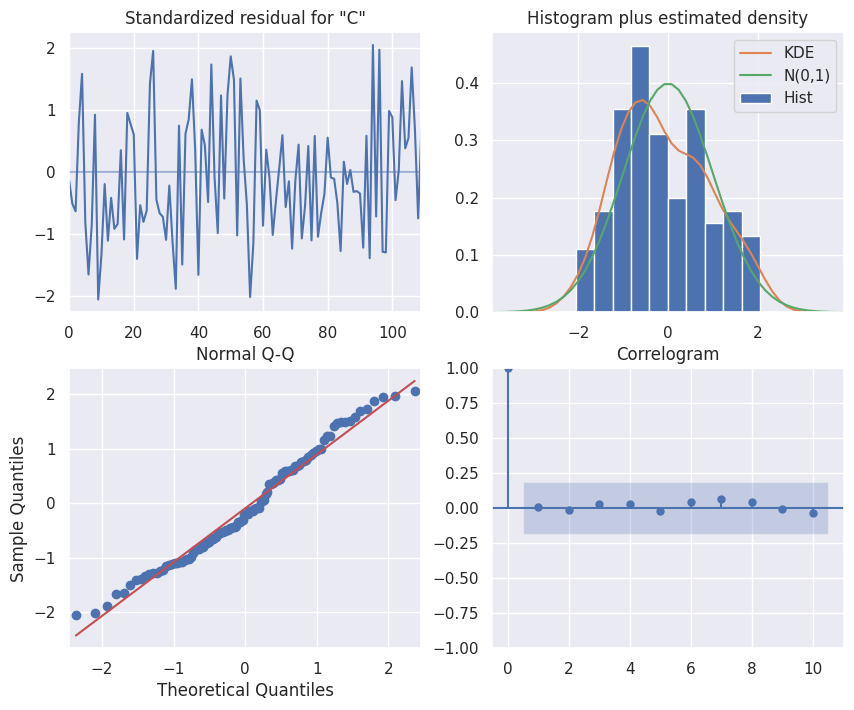

In [177]:
print(arima_model_fit.summary())

arima_model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

1277340.5539163614


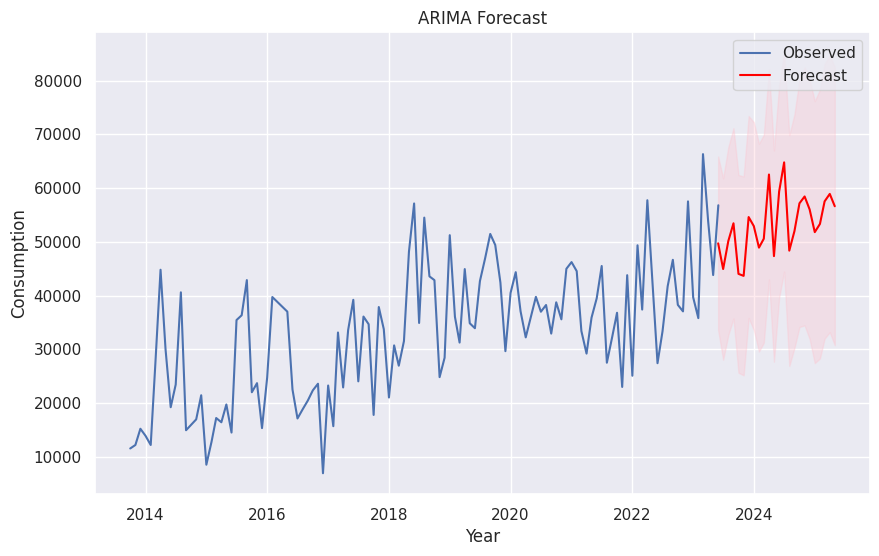

In [186]:
# Forecasting
n_month = 24  # Number of future time points to forecast
forecast = arima_model_fit.forecast(steps=n_month)
print(forecast.sum())
data_ts['Month'] = pd.to_datetime(data_ts['Month'], format='%Y%m')

F2 = arima_model_fit.get_forecast(steps=n_month)
yhat = F2.predicted_mean
yhat_conf_int = F2.conf_int(alpha=0.05)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data_ts['Month'], data_ts['Consumption'],  label='Observed')
plt.plot(pd.date_range(start='2023-05', periods=24, freq='M', closed='right'), forecast, label='Forecast', color='red')
plt.fill_between(pd.date_range(start='2023-05', periods=24, freq='M', closed='right'), yhat_conf_int.iloc[:, 0], yhat_conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.legend()
plt.show()


# Comparing Models

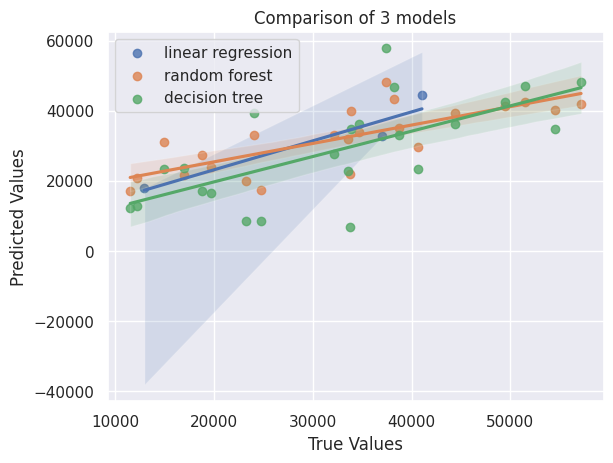

In [179]:
sns.regplot(x=y_test, y=linear_regression_predictions_test, label='linear regression')
sns.regplot(x=y_test_2, y=random_forest_predictions_test, label='random forest')

sns.regplot(x=y_test_2, y=decision_tree_predictions_test, label='decision tree')

# Set plot labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of 3 models')

# Add legend
plt.legend()

# Predict the next 24 month

In [180]:
class pred_consumtion:
    def __init__(self, year_now, month_now, length, SM):
        # Linear Regression for yearly
        nYear = int(length/12)
     
        months, years = [], []
        m0 = month_now
        yi = year_now
        while len(months) < length:
            while m0 < 13 and len(months) < length:
                months.append(m0)
                years.append(yi)
                m0+=1
            m0 = 1
            yi +=1
        self.X_df = pd.DataFrame()
        self.X_df['Year']= years
        self.X_df['Month'] = months

        self.SM = SM
    

    def monthly(self, model, RMSE):

        safety_margin = self.SM / 100 * RMSE
    
        self.pred = int(model.predict(self.X_df).sum() )
        self.pred2 = int(self.pred + safety_margin)
        self.print_pred(RMSE)

    def yearly(self, model, RMSE):
        
        X2 =pd.DataFrame()
        X2['Year'] = self.X_df.loc[:, 'Year'].unique()
        # count number of month per year
        count = []
        for xi in X2.Year:
            yr_msk = self.X_df['Year'] == xi
            count.append(self.X_df.loc[yr_msk].Year.count())
        
        X = X2.loc[:, 'Year'].values.reshape(-1, 1)
        pred = model.predict(X)* np.array(count)/12

        safety_margin = self.SM / 100 * RMSE

        self.pred = int(pred.sum())
        self.pred2 = int(self.pred + safety_margin)
        self.print_pred(RMSE)

    def print_pred(self, RMSE):
        print(f'  - RMSE on the test data: {int(RMSE)}')
        print(f'  - The future cost prediction: {self.pred}'),
        print(f'  - with {self.SM}% safety margin = {self.pred2}\n')
        
SM = 20
P = pred_consumtion(2023, 5, 24, SM)
print('------------------------------------------')
print('Linear Regression:')
P.yearly(linear_regression_model, linear_regression_rmse)

print('------------------------------------------')
print('Decision Tree:')
P.monthly(decision_tree_model,decision_tree_rmse)
print('------------------------------------------')
print('Random Forest:')
P.monthly(random_forest_model, random_forest_rmse)
    

------------------------------------------
Linear Regression:
  - RMSE on the test data: 4295
  - The future cost prediction: 99622
  - with 20% safety margin = 100481

------------------------------------------
Decision Tree:
  - RMSE on the test data: 11642
  - The future cost prediction: 1274226
  - with 20% safety margin = 1276554

------------------------------------------
Random Forest:
  - RMSE on the test data: 8578
  - The future cost prediction: 1216552
  - with 20% safety margin = 1218267



# Storing the trained models

In [181]:
import pickle

with open("../model/linear_regression.pkl", "wb") as pickler1:
    pickle.dump(linear_regression_model, pickler1)


with open("../model/random_forest.pkl", "wb") as pickler2:
    pickle.dump(random_forest_model, pickler2)


with open("../model/decision_tree.pkl", "wb") as pickler3:
    pickle.dump(decision_tree_model, pickler3)

In [182]:
# saving RMSE

rmse_out = pd.DataFrame()
rmse_out['linear_regression'] = [linear_regression_rmse]
rmse_out['random_forest'] = [random_forest_rmse]
rmse_out['decision_tree'] = [decision_tree_rmse]

rmse_out.to_csv('../model/rmse.csv', index=False)

In [183]:
# ourput train and test data for streamlit demo

# Linear Regression 
linear_regression_train = pd.DataFrame({'y': y_train, 'y_pred':linear_regression_predictions_train})
linear_regression_test = pd.DataFrame({'y': y_test, 'y_pred':linear_regression_predictions_test})

linear_regression_train.to_csv('../data/linear_regression_train.csv', index=False)
linear_regression_test.to_csv('../data/linear_regression_test.csv', index=False)

# Random forest
random_forest_train = pd.DataFrame({'y': y_train_2, 'y_pred':random_forest_predictions_train})
random_forest_test = pd.DataFrame({'y': y_test_2, 'y_pred':random_forest_predictions_test})

random_forest_train.to_csv('../data/random_forest_train.csv', index=False)
random_forest_test.to_csv('../data/random_forest_test.csv', index=False)


# Decision tree
decision_tree_train = pd.DataFrame({'y': y_train_2, 'y_pred':decision_tree_predictions_train})
decision_tree_test = pd.DataFrame({'y': y_test_2, 'y_pred':decision_tree_predictions_test})

decision_tree_train.to_csv('../data/decision_tree_train.csv', index=False)
decision_tree_test.to_csv('../data/decision_tree_test.csv', index=False)